<a href="https://colab.research.google.com/github/Mc4minta/AIB5-PcapAttackClassifier/blob/main/BenignAttack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# objective : train model that classify attack and benign,
- binary classification

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import os

csv_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/GeneratedLabelledFlows/TrafficLabelling'

csv_files = [
    'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',     # Benign, DDOS,
    'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', # Benign, Portscan
    'Monday-WorkingHours.pcap_ISCX.csv',                    # Benign
    'Tuesday-WorkingHours.pcap_ISCX.csv',                   # Benign, FTP, SSH
    'Wednesday-workingHours.pcap_ISCX.csv',                 # Benign, DOSs, Heartbleed

    #'Thursday-WorkingHours-Morning-WebAttacks-Fix.pcap_ISCX.csv' # Benign, Web attacks (Fixed)

    # 'Friday-WorkingHours-Morning.pcap_ISCX.csv',          # Benign, Bot
    # 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv' # Benign, Web attacks
    # 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', # Benign, Infiltration
]

dfs = []

for file in csv_files:
    file_path = os.path.join(csv_dir, file)
    try:
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip().str.replace(' ', '_')  # Clean column names

        if 'Label' not in df.columns:
            print(f"Label column missing in: {file}")
            continue

        # Drop 65% of BENIGN samples
        benign_df = df[df['Label'] == 'BENIGN']
        non_benign_df = df[df['Label'] != 'BENIGN']

        # Drop 65% of BENIGN samples randomly
        dropped_benign = benign_df.sample(frac=0.35, random_state=42)

        # Concatenate back with attack samples
        reduced_df = pd.concat([dropped_benign, non_benign_df], ignore_index=True)

        dfs.append(reduced_df)
        print(f"Loaded and reduced BENIGN in: {file}")

    except FileNotFoundError:
        print(f"File not found: {file}")
    except Exception as e:
        print(f"Error with {file}: {e}")

# Combine all files
df = pd.concat(dfs, ignore_index=True)

# Drop unneeded columns
columns_to_drop = [
    'Flow_ID', 'Source_IP', 'Destination_IP', 'Protocol', 'Timestamp', 'Fwd_Header_Length.1',
]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Clean infinite or missing values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

df.head()

Loaded and reduced BENIGN in: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Loaded and reduced BENIGN in: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Loaded and reduced BENIGN in: Monday-WorkingHours.pcap_ISCX.csv
Loaded and reduced BENIGN in: Tuesday-WorkingHours.pcap_ISCX.csv
Loaded and reduced BENIGN in: Wednesday-workingHours.pcap_ISCX.csv


,Source_Port,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,80,40474,7182757,1,5,6.0,30.0,6.0,6.0,6.0,...,20,45201.000,0.000,45201.0,45201.0,7137556.0,0.00,7137556.0,7137556.0,BENIGN
1,80,28907,938509,1,5,6.0,30.0,6.0,6.0,6.0,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
2,0,0,119995732,123,0,0.0,0.0,0.0,0.0,0.0,...,0,3753432.167,5183854.063,13200000.0,1.0,13100000.0,6507819.26,26300000.0,6484077.0,BENIGN
3,58168,443,142954,10,6,553.0,3949.0,196.0,0.0,55.3,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
4,80,17541,2548725,1,6,6.0,36.0,6.0,6.0,6.0,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN


In [3]:
columns_mapping = {
    'Src_Port': 'Source_Port',
    'Dst_Port': 'Destination_Port',
    'Flow_Duration': 'Flow_Duration',
    'Tot_Fwd_Pkts': 'Total_Fwd_Packets',
    'Tot_Bwd_Pkts': 'Total_Backward_Packets',
    'TotLen_Fwd_Pkts': 'Total_Length_of_Fwd_Packets',
    'TotLen_Bwd_Pkts': 'Total_Length_of_Bwd_Packets',
    'Fwd_Pkt_Len_Max': 'Fwd_Packet_Length_Max',
    'Fwd_Pkt_Len_Min': 'Fwd_Packet_Length_Min',
    'Fwd_Pkt_Len_Mean': 'Fwd_Packet_Length_Mean',
    'Fwd_Pkt_Len_Std': 'Fwd_Packet_Length_Std',
    'Bwd_Pkt_Len_Max': 'Bwd_Packet_Length_Max',
    'Bwd_Pkt_Len_Min': 'Bwd_Packet_Length_Min',
    'Bwd_Pkt_Len_Mean': 'Bwd_Packet_Length_Mean',
    'Bwd_Pkt_Len_Std': 'Bwd_Packet_Length_Std',
    'Flow_Byts/s': 'Flow_Bytes/s',
    'Flow_Pkts/s': 'Flow_Packets/s',
    'Flow_IAT_Mean': 'Flow_IAT_Mean',
    'Flow_IAT_Std': 'Flow_IAT_Std',
    'Flow_IAT_Max': 'Flow_IAT_Max',
    'Flow_IAT_Min': 'Flow_IAT_Min',
    'Fwd_IAT_Tot': 'Fwd_IAT_Total',
    'Fwd_IAT_Mean': 'Fwd_IAT_Mean',
    'Fwd_IAT_Std': 'Fwd_IAT_Std',
    'Fwd_IAT_Max': 'Fwd_IAT_Max',
    'Fwd_IAT_Min': 'Fwd_IAT_Min',
    'Bwd_IAT_Tot': 'Bwd_IAT_Total',
    'Bwd_IAT_Mean': 'Bwd_IAT_Mean',
    'Bwd_IAT_Std': 'Bwd_IAT_Std',
    'Bwd_IAT_Max': 'Bwd_IAT_Max',
    'Bwd_IAT_Min': 'Bwd_IAT_Min',
    'Fwd_PSH_Flags': 'Fwd_PSH_Flags',
    'Bwd_PSH_Flags': 'Bwd_PSH_Flags',
    'Fwd_URG_Flags': 'Fwd_URG_Flags',
    'Bwd_URG_Flags': 'Bwd_URG_Flags',
    'Fwd_Header_Len': 'Fwd_Header_Length',
    'Bwd_Header_Len': 'Bwd_Header_Length',
    'Fwd_Pkts/s': 'Fwd_Packets/s',
    'Bwd_Pkts/s': 'Bwd_Packets/s',
    'Pkt_Len_Min': 'Min_Packet_Length',
    'Pkt_Len_Max': 'Max_Packet_Length',
    'Pkt_Len_Mean': 'Packet_Length_Mean',
    'Pkt_Len_Std': 'Packet_Length_Std',
    'Pkt_Len_Var': 'Packet_Length_Variance',
    'FIN_Flag_Cnt': 'FIN_Flag_Count',
    'SYN_Flag_Cnt': 'SYN_Flag_Count',
    'RST_Flag_Cnt': 'RST_Flag_Count',
    'PSH_Flag_Cnt': 'PSH_Flag_Count',
    'ACK_Flag_Cnt': 'ACK_Flag_Count',
    'URG_Flag_Cnt': 'URG_Flag_Count',
    'CWE_Flag_Count': 'CWE_Flag_Count',
    'ECE_Flag_Cnt': 'ECE_Flag_Count',
    'Down/Up_Ratio': 'Down/Up_Ratio',
    'Pkt_Size_Avg': 'Average_Packet_Size',
    'Fwd_Seg_Size_Avg': 'Avg_Fwd_Segment_Size',
    'Bwd_Seg_Size_Avg': 'Avg_Bwd_Segment_Size',
    'Fwd_Byts/b_Avg': 'Fwd_Byts/b_Avg',
    'Fwd_Pkts/b_Avg': 'Fwd_Pkts/b_Avg',
    'Fwd_Blk_Rate_Avg': 'Fwd_Blk_Rate_Avg',
    'Bwd_Byts/b_Avg': 'Bwd_Byts/b_Avg',
    'Bwd_Pkts/b_Avg': 'Bwd_Pkts/b_Avg',
    'Bwd_Blk_Rate_Avg': 'Bwd_Blk_Rate_Avg',
    'Subflow_Fwd_Pkts': 'Subflow_Fwd_Pkts',
    'Subflow_Fwd_Byts': 'Subflow_Fwd_Byts',
    'Subflow_Bwd_Pkts': 'Subflow_Bwd_Pkts',
    'Subflow_Bwd_Byts': 'Subflow_Bwd_Byts',
    'Init_Fwd_Win_Byts': 'Init_Fwd_Win_Byts',
    'Init_Bwd_Win_Byts': 'Init_Bwd_Win_Byts',
    'Fwd_Act_Data_Pkts': 'act_data_pkt_fwd',
    'Fwd_Seg_Size_Min': 'Fwd_Seg_Size_Min',
    'Active_Mean': 'Active_Mean',
    'Active_Std': 'Active_Std',
    'Active_Max': 'Active_Max',
    'Active_Min': 'Active_Min',
    'Idle_Mean': 'Idle_Mean',
    'Idle_Std': 'Idle_Std',
    'Idle_Max': 'Idle_Max',
    'Idle_Min': 'Idle_Min'
}


df = df.rename(columns=columns_mapping)
df = df.dropna()
df.head()

,Source_Port,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,80,40474,7182757,1,5,6.0,30.0,6.0,6.0,6.0,...,20,45201.000,0.000,45201.0,45201.0,7137556.0,0.00,7137556.0,7137556.0,BENIGN
1,80,28907,938509,1,5,6.0,30.0,6.0,6.0,6.0,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
2,0,0,119995732,123,0,0.0,0.0,0.0,0.0,0.0,...,0,3753432.167,5183854.063,13200000.0,1.0,13100000.0,6507819.26,26300000.0,6484077.0,BENIGN
3,58168,443,142954,10,6,553.0,3949.0,196.0,0.0,55.3,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
4,80,17541,2548725,1,6,6.0,36.0,6.0,6.0,6.0,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN


In [4]:
# Remove unused attacks rows
values_to_remove = ['Bot', 'Heartbleed']
df = df[~df['Label'].isin(values_to_remove)]
df = df.reset_index(drop=True)
df['Label'].value_counts()

,count
Label,
BENIGN,569110
DoS Hulk,230124
PortScan,158804
DDoS,128025
DoS GoldenEye,10293
FTP-Patator,7935
SSH-Patator,5897
DoS slowloris,5796
DoS Slowhttptest,5499


In [5]:
# Groupped DOS Labels and rename FTP and SSH to be bruteforce
label_mapping = {
    'BENIGN': 'Benign',
    'DoS Hulk': 'Attack',
    'DDoS': 'Attack',
    'DoS GoldenEye': 'Attack',
    'DoS slowloris': 'Attack',
    'DoS Slowhttptest': 'Attack',
    'PortScan' : 'Attack',
    'FTP-Patator': 'Attack',
    'SSH-Patator': 'Attack',
}

# Apply the label mapping to the 'Label' column
df['Label'] = df['Label'].map(label_mapping)
df['Label'].value_counts()

,count
Label,
Benign,569110
Attack,552373


In [6]:
df = df[~((df['Label'] == 'Benign') & df.duplicated())]
df['Label'].value_counts()

,count
Label,
Benign,567789
Attack,552373


In [7]:
# prompt: compare the count of benigh label row and all other label row combine

benign_count = len(df[df['Label'] == 'Benign'])
other_labels_count = len(df[df['Label'] != 'Benign'])

print(f"Benign: {benign_count}")
print(f"Attack: {other_labels_count}")

Benign: 567789
Attack: 552373


In [8]:
# Sample mapping function
def map_port(port):
    if port == 21:
        return 'FTP'
    elif port == 22:
        return 'SSH'
    elif port == 53:
        return 'DNS'
    elif port == 80:
        return 'HTTP'
    elif port == 443:
        return 'HTTPS'
    else:
        return 'Other'

# Example DataFrame (replace this with your actual df)
# df = pd.read_csv('your_data.csv')

# Apply port mapping
df['Source_Port'] = df['Source_Port'].apply(map_port)
df['Destination_Port'] = df['Destination_Port'].apply(map_port)

# One-hot encode categorical port fields
df = pd.get_dummies(df, columns=['Source_Port', 'Destination_Port'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1120162 entries, 0 to 1121482
Data columns (total 89 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Flow_Duration                1120162 non-null  int64  
 1   Total_Fwd_Packets            1120162 non-null  int64  
 2   Total_Backward_Packets       1120162 non-null  int64  
 3   Total_Length_of_Fwd_Packets  1120162 non-null  float64
 4   Total_Length_of_Bwd_Packets  1120162 non-null  float64
 5   Fwd_Packet_Length_Max        1120162 non-null  float64
 6   Fwd_Packet_Length_Min        1120162 non-null  float64
 7   Fwd_Packet_Length_Mean       1120162 non-null  float64
 8   Fwd_Packet_Length_Std        1120162 non-null  float64
 9   Bwd_Packet_Length_Max        1120162 non-null  float64
 10  Bwd_Packet_Length_Min        1120162 non-null  float64
 11  Bwd_Packet_Length_Mean       1120162 non-null  float64
 12  Bwd_Packet_Length_Std        1120162 non-null  

In [11]:
df.head()

,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,Bwd_Packet_Length_Max,...,Source_Port_HTTP,Source_Port_HTTPS,Source_Port_Other,Source_Port_SSH,Destination_Port_DNS,Destination_Port_FTP,Destination_Port_HTTP,Destination_Port_HTTPS,Destination_Port_Other,Destination_Port_SSH
0,7182757,1,5,6.0,30.0,6.0,6.0,6.0,0.000000,6.0,...,True,False,False,False,False,False,False,False,True,False
1,938509,1,5,6.0,30.0,6.0,6.0,6.0,0.000000,6.0,...,True,False,False,False,False,False,False,False,True,False
2,119995732,123,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,False,False,True,False,False,False,False,False,True,False
3,142954,10,6,553.0,3949.0,196.0,0.0,55.3,71.704719,2860.0,...,False,False,True,False,False,False,False,True,False,False
4,2548725,1,6,6.0,36.0,6.0,6.0,6.0,0.000000,6.0,...,True,False,False,False,False,False,False,False,True,False


In [12]:
def plot_feature_importances(df, model):
  # Calculate feature importances
  importances = model.feature_importances_

  import matplotlib.pyplot as plt
  import numpy as np

  # Sort feature importances in descending order
  X = df.iloc[:, :-1]
  feature_names = X.columns
  indices = np.argsort(importances)[::-1]

  # Adjust plot height dynamically based on number of features
  num_features = X.shape[1]
  plt.figure(figsize=(15, num_features * 0.2))  # Increase height proportionally

  # Plot horizontal bar chart with smaller bar height
  plt.barh(range(num_features), importances[indices], align="center", height=0.5)
  plt.yticks(range(num_features), [feature_names[i] for i in indices])
  plt.gca().invert_yaxis()  # Most important on top
  plt.title("Feature Importances")
  plt.tight_layout()
  plt.show()

  for i in indices: print(f"{feature_names[i]} : {importances[i]}")

In [13]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Split features and labels
X = df.drop('Label', axis=1)
y = df['Label']

# First split: Train + Temp (Val + Test)
X_train_full, X_temp, y_train_full, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: Val + Test from Temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check shapes (optional)
print(f"Train size: {X_train_full.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 896129
Validation size: 112016
Test size: 112017


In [14]:
# Train the model
model = RandomForestClassifier(n_estimators=400, random_state=42)
model.fit(X_train_full, y_train_full)

RandomForestClassifier(n_estimators=400, random_state=42)

In [15]:
import joblib

# Optional: Save the model using joblib
joblib.dump(model, '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/BenignAttackRf.pkl')

['/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/BenignAttackRf.pkl']

Validation Accuracy: 0.9995714897871733
Test Accuracy: 0.9997411107242651


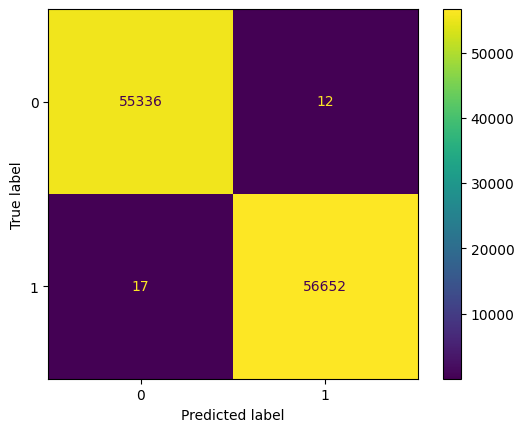

In [16]:
# (Optional) Evaluate on Validation set
val_preds = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)
print("Validation Accuracy:", val_accuracy)

# Final evaluation on Test set
test_preds = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)
print("Test Accuracy:", test_accuracy)

# Optional: display confusion matrix
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Accuracy: 0.9997
Recall for Attack: 0.9998
Recall for Benign: 0.9997

Overall Recall (Macro Average): 0.9997


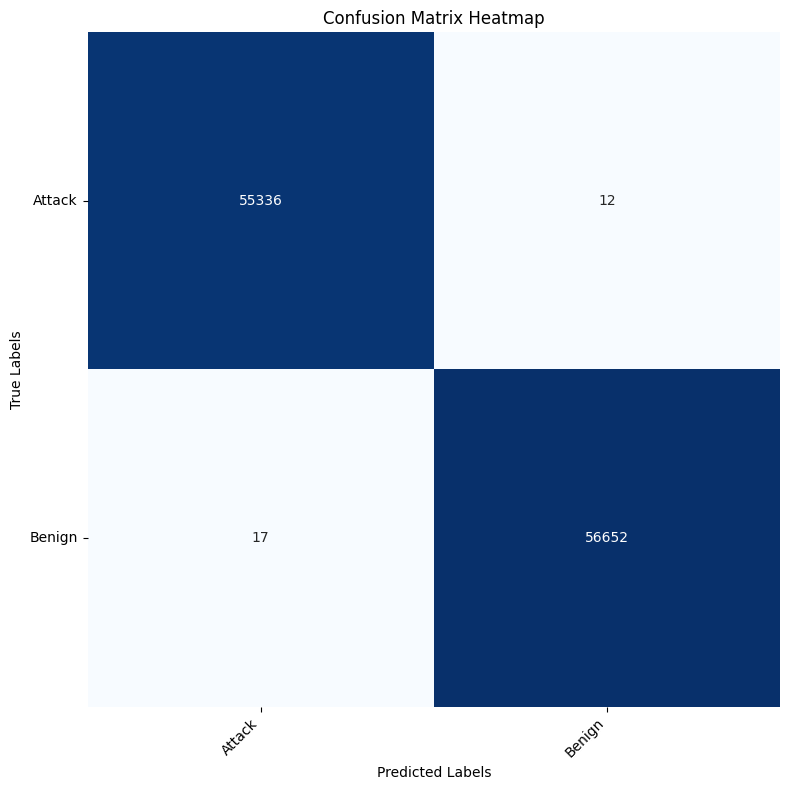

In [17]:
# y_pred
import matplotlib.pyplot as plt
import seaborn as sns

target_names = y_train_full.unique()
accuracy = accuracy_score(y_test, test_preds)
print(f'Accuracy: {accuracy:.4f}')

recall_per_class = recall_score(y_test, test_preds, average=None)  # average=None for per-class scores
for i, class_name in enumerate(target_names):
    print(f"Recall for {class_name}: {recall_per_class[i]:.4f}")

# Print overall recall (macro average)
overall_recall = recall_score(y_test, test_preds, average='macro')  # macro average
print(f"\nOverall Recall (Macro Average): {overall_recall:.4f}")

conf_matrix = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(8, 8)) # Increase figure size for better readability
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=target_names, yticklabels=target_names)

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better visibility
plt.yticks(rotation=0) # Keep y-axis labels vertical
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

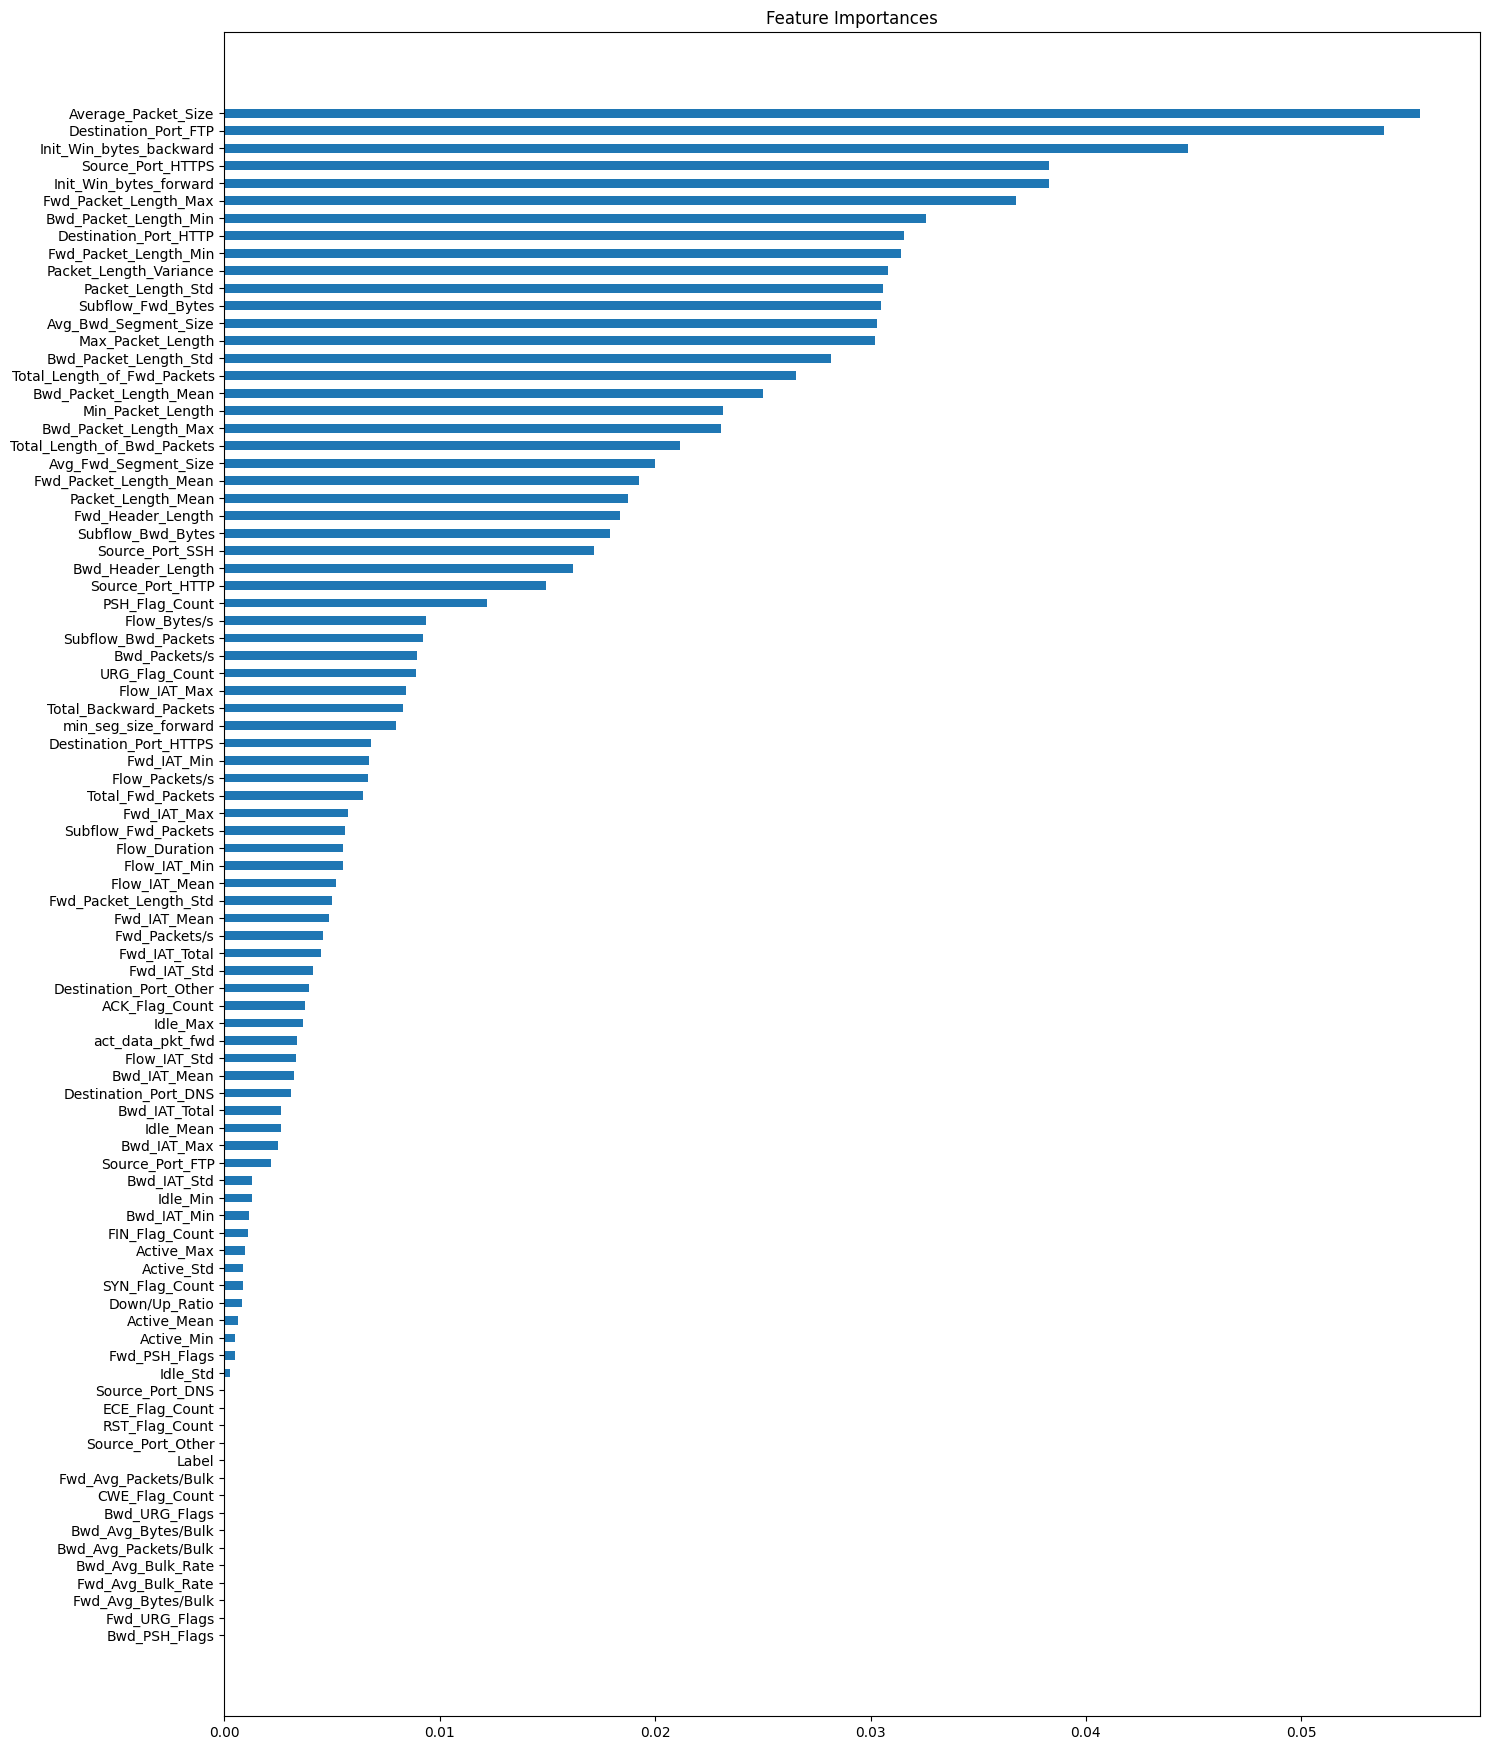

Average_Packet_Size : 0.055519684619177355
Destination_Port_FTP : 0.0538363584474455
Init_Win_bytes_backward : 0.04471791313553733
Source_Port_HTTPS : 0.038292176206907114
Init_Win_bytes_forward : 0.038287113537311304
Fwd_Packet_Length_Max : 0.03674032892171544
Bwd_Packet_Length_Min : 0.03255766037301512
Destination_Port_HTTP : 0.031535210418467956
Fwd_Packet_Length_Min : 0.031394668095809396
Packet_Length_Variance : 0.03079653476658065
Packet_Length_Std : 0.03056587103028972
Subflow_Fwd_Bytes : 0.03046998076794809
Avg_Bwd_Segment_Size : 0.03032331792861409
Max_Packet_Length : 0.030184500274882127
Bwd_Packet_Length_Std : 0.028153260412314033
Total_Length_of_Fwd_Packets : 0.02654094996588691
Bwd_Packet_Length_Mean : 0.02498889448922882
Min_Packet_Length : 0.02313725349832497
Bwd_Packet_Length_Max : 0.023049567533064592
Total_Length_of_Bwd_Packets : 0.02114907316013059
Avg_Fwd_Segment_Size : 0.020000144831609893
Fwd_Packet_Length_Mean : 0.019272801381557802
Packet_Length_Mean : 0.0187564

In [18]:
plot_feature_importances(df,model)